<a href="https://colab.research.google.com/github/drsunithaev/FDP_DL_CV/blob/main/7_keras_tuner_and_mnist_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**HYPER PARAMETER TUNING**

# Install Keras Tuner

In [ ]:
!pip install keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np

In [ ]:
print(tf.__version__)

# Import data FASION MNIST

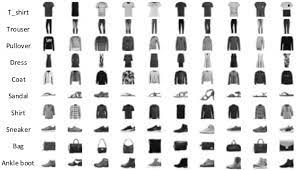

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist

In [ ]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Scaling data to 0-1

In [ ]:
np.min(train_images)

In [ ]:
np.max(train_images)

In [ ]:
np.min(test_images)

In [ ]:
np.max(test_images)

In [ ]:
train_images = train_images/255.0
test_images = test_images/255.0

In [ ]:
print("Train Minimum", np.min(train_images))
print("Train Maximum",np.max(train_images))
print("Test Minimum",np.min(test_images))
print("Test Maximum",np.max(test_images))

In [ ]:
train_images[0].shape

In [ ]:
train_images[0]

## Reshaping the data to feed it to CNN

In [ ]:
train_images = train_images.reshape(len(train_images), 28,28,1)
test_images = test_images.reshape(len(test_images), 28,28,1)

## Tuning function

### hp - hyper parameter
##Tuners
- RandomSearch Tuner
- Hyperband Tuner
- BayesianOptimization Tuner

##RandomSearch concept:

- One way to find the optimal parameters is to try every possible combinations of the available parameters [Grid Search], but the number of combinations would increase exponentially as the number of hyperparameters increases. Trying all the combinations one by one takes longer to explore the hyperparameter space. Random search helps to explore more hyperparameter space in less time as compared to Grid Search. Exploring more hyperparameter space does not guarantee the absolute optimal results but close to optimal. 

##Hyperband Concept:

- This technique tries to remove one of the problems in random search of hyperparameters. Problem is as follows: Random search may pick some values which are very obviously bad and will do full training and evaluation on it, which is wasteful. Hyperband provides one way to solve this problem. Hyperband Solution: Randomly sample all the combinations of hyperparameter and now instead of running full training and evaluation on it, train the model for few epochs (less than max_epochs) with these combinations and select the best candidates based on the results on these few epochs. It does this iteratively and finally runs full training and evaluation on the final chosen candidates. The number of iterations done depends on parameter ‘hyperband_iterations’ and number of epochs in each iteration are less than ‘max_epochs’.

##Bayesian Optimization tuner Concept:

- This techniques addresses a common problem in RandomSearch and Hyperband. Problem: All the hyperparameter combinations are chosen randomly. Choosing hyperparameters randomly helps to explore the hyperparameter space but does not guarantee absolute optimal hyperparameters. Solution provided by BayesianOptimization tuner: Instead of all combinations being random, it chooses first few randomly, then based on the performance on these hyperparameters it chooses the next best possible hyperparameters. Hence it takes into account the history of the hyperparameters which were tried. The iterations of choosing next set of hyperparameters based on history and evaluating performance continues till the tuner reaches optimal hyperparameters or exhausts maximum number of allowed trails. Maximum trials are set using parameter ‘max_trails’.

In [ ]:
def build_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(28,28,1)
    ),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'
    ),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(10, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [ ]:
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters


In [ ]:
tuner_search = RandomSearch(build_model,
                          objective='val_accuracy',
                          max_trials=5,directory='output',project_name="Mnist Fashion")

In [ ]:
tuner_search.search(train_images,train_labels,epochs=3,validation_split=0.1)

In [ ]:
model=tuner_search.get_best_models(num_models=1)[0]

In [ ]:
model.summary()

In [ ]:
model.fit(train_images, train_labels, epochs=10, validation_split=0.1, initial_epoch=3)

In [ ]:
loss, accuracy = model.evaluate(test_images, test_labels)

In [ ]:
loss


In [ ]:
accuracy

In [ ]:
tuner_search.results_summary()

# ------------------------- END -----------------------------------------------

In [ ]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#make float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')


# input image dimensions
img_rows, img_cols = 28, 28
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)

x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)



input_shape = (img_rows, img_cols, 1)
print(input_shape)

In [ ]:
NUM_CLASSES = 10
INPUT_SHAPE = input_shape


In [ ]:
from kerastuner import HyperModel
from tensorflow.keras.layers import (
    Conv2D,
    Dense,
    Dropout,
    Flatten,
    MaxPooling2D
)

class MNIST_CNN_HyperModel(HyperModel):
  def __init__(self, input_shape, num_classes):
    self.input_shape = INPUT_SHAPE
    self.num_classes = NUM_CLASSES
  
  def build(self,hp):
    model = keras.Sequential()
    model.add(
        Conv2D(
            filters = 32,
            kernel_size = 3,
            activation = 'relu',
            input_shape = self.input_shape
        )
    )

    model.add(
        Conv2D(
            filters = 64,
            kernel_size = 3,
            activation = 'relu'
        )
    )

    model.add(MaxPooling2D(pool_size = 2))

    model.add(
        Dropout(rate = hp.Float(
            'dropout_1',
            min_value = 0.0,
            max_value = 0.5,
            default = 0.25,
            step = 0.05
        ))
    )

    model.add(Flatten())

    model.add(
        Dense(
            units = hp.Int(
                'units',
                min_value = 32,
                max_value = 512,
                step = 32,
                default = 128
            ),
            activation = hp.Choice(
                'dense_activation',
                values = ['relu','tanh','sigmoid'],
                default = 'relu'
            )
        )
    )

    model.add(
        Dropout(
            rate = hp.Float(
                'dropout_3',
                min_value = 0.25,
                max_value = 0.75,
                default = 0.5,
                step = 0.05
            )
        )
    )

    model.add(
        Dense(
            self.num_classes,
            activation = 'softmax'
        )
    )

    model.compile(
        optimizer = keras.optimizers.Adadelta(
            hp.Float(
                'learning_rate',
                min_value = 1e-4,
                max_value = 1e-2,
                sampling = 'LOG',
                default = 1e-3
            )
        ),
        loss=keras.losses.sparse_categorical_crossentropy,
        metrics=['accuracy']
    )
    return model

In [ ]:
hypermodel = MNIST_CNN_HyperModel(input_shape = INPUT_SHAPE, num_classes=NUM_CLASSES)

In [ ]:
HYPERBAND_MAX_EPOCHS = 20
MAX_TRIALS = 20
EXECUTION_PER_TRIAL = 2
SEED = 4
INPUT_SHAPE = (28,28,1)
NUM_CLASSES = 10

In [ ]:
# Choosing Tuner from Keras Tuner 
from kerastuner.tuners import RandomSearch

tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    seed=SEED,
    max_trials=MAX_TRIALS,
    executions_per_trial=EXECUTION_PER_TRIAL
)

In [ ]:
tuner.search_space_summary()

In [ ]:
N_EPOCH_SEARCH = 20

tuner.search(x_train, y_train, epochs=N_EPOCH_SEARCH, validation_data = (x_test,y_test))

In [ ]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]
print(best_model)

# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_test, y_test)
print(loss)
print(accuracy)

In [ ]:
from kerastuner.tuners import Hyperband


tuner = Hyperband(
    hypermodel,
    max_epochs=HYPERBAND_MAX_EPOCHS,
    objective='val_accuracy',
    seed=SEED,
    executions_per_trial=EXECUTION_PER_TRIAL,
    project_name = 'MNIST')

In [ ]:
N_EPOCH_SEARCH = 20

tuner.search(x_train, y_train, epochs=N_EPOCH_SEARCH, validation_data = (x_test,y_test))

In [ ]:
# Show a summary of the search
tuner.results_summary()

# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]
print(best_model)

# Evaluate the best model.
loss, accuracy = best_model.evaluate(x_test, y_test)
print(loss)
print(accuracy)